### Example 2: Nonlinear convection in 2D

Following the initial convection tutorial with a single state variable $u$, we will now look at non-linear convection (step 6 in the original). This brings one new crucial challenge: computing a pair of coupled equations and thus updating two time-dependent variables $u$ and $v$.

The full set of coupled equations is now

\begin{aligned}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = 0 \\
\\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = 0\\
\end{aligned}

and rearranging the discretized version gives us an expression for the update of both variables

\begin{aligned}
u_{i,j}^{n+1} &= u_{i,j}^n - u_{i,j} \frac{\Delta t}{\Delta x} (u_{i,j}^n-u_{i-1,j}^n) - v_{i,j}^n \frac{\Delta t}{\Delta y} (u_{i,j}^n-u_{i,j-1}^n) \\
\\
v_{i,j}^{n+1} &= v_{i,j}^n - u_{i,j} \frac{\Delta t}{\Delta x} (v_{i,j}^n-v_{i-1,j}^n) - v_{i,j}^n \frac{\Delta t}{\Delta y} (v_{i,j}^n-v_{i,j-1}^n)
\end{aligned}

So, for starters we will re-create the original example run in pure NumPy array notation, before demonstrating 
the Devito version. Let's start again with some utilities and parameters:

In [1]:
from examples.cfd import plot_field, init_hat
import numpy as np
import sympy
%matplotlib inline

# Some variable declarations
nx = 101
ny = 101
nt = 80
c = 1.
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
sigma = .2
dt = sigma * dx

Let's re-create the initial setup with a 2D "hat function", but this time for two state variables.

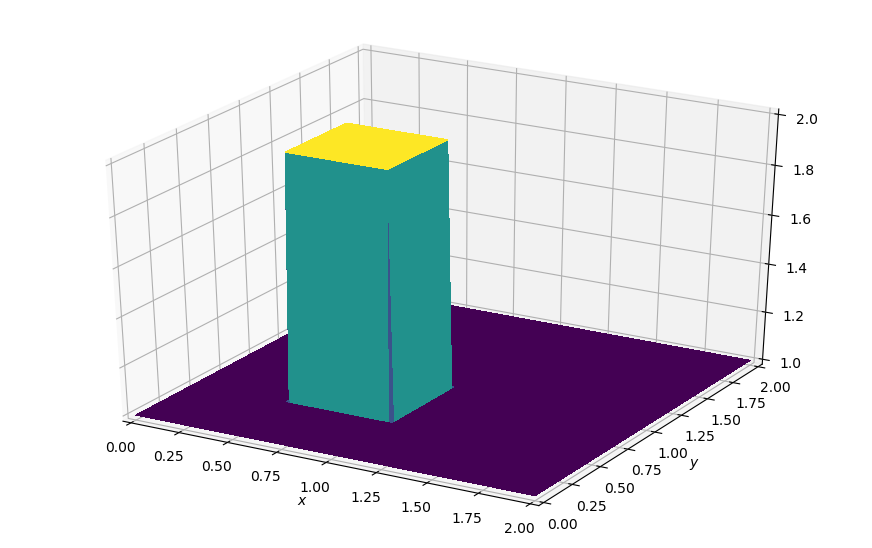

In [2]:
#NBVAL_IGNORE_OUTPUT

# Allocate fields and assign initial conditions
u = np.empty((nx, ny))
v = np.empty((nx, ny))

init_hat(field=u, dx=dx, dy=dy, value=2.)
init_hat(field=v, dx=dx, dy=dy, value=2.)

plot_field(u)

Now we can create the two stencil expression for our two coupled equations according to the discretized equation above. We again use some simple Dirichlet boundary conditions to keep the values on all sides constant.

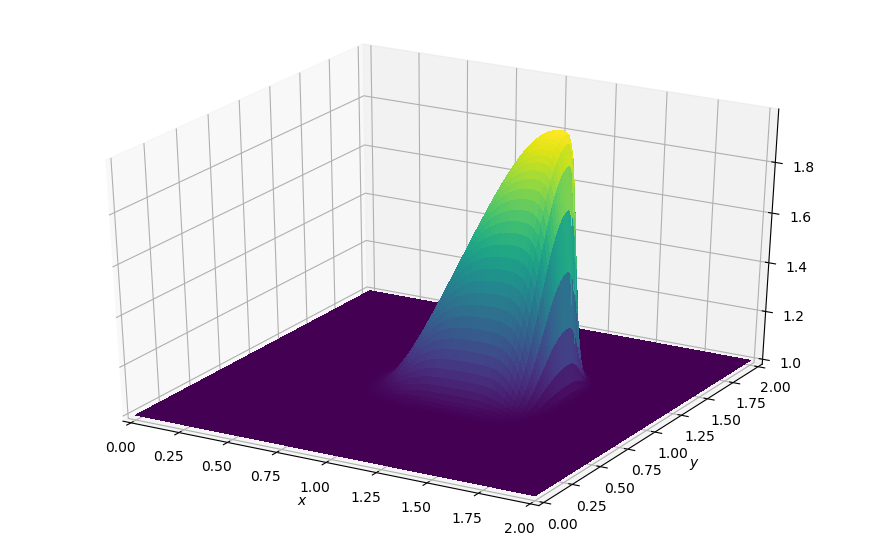

In [3]:
#NBVAL_IGNORE_OUTPUT
for n in range(nt + 1): ##loop across number of time steps
    un = u.copy()
    vn = v.copy()
    u[1:, 1:] = (un[1:, 1:] - 
                 (un[1:, 1:] * c * dt / dx * (un[1:, 1:] - un[1:, :-1])) -
                  vn[1:, 1:] * c * dt / dy * (un[1:, 1:] - un[:-1, 1:]))
    v[1:, 1:] = (vn[1:, 1:] -
                 (un[1:, 1:] * c * dt / dx * (vn[1:, 1:] - vn[1:, :-1])) -
                 vn[1:, 1:] * c * dt / dy * (vn[1:, 1:] - vn[:-1, 1:]))
    
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1
    
plot_field(u)

Excellent, we again get a wave that resembles the one from the oiginal examples.

Now we can set up our coupled problem in Devito. Let's start by creating two initial state variables $u$ and $v$, as before, and intialising them with our "hat function.

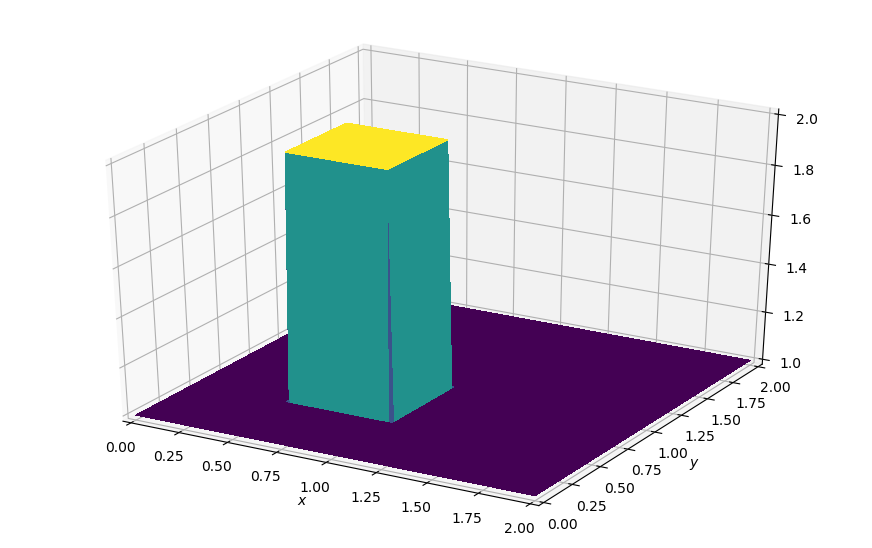

In [4]:
#NBVAL_IGNORE_OUTPUT
from devito import Grid, TimeFunction

# First we need two time-dependent data fields, both initialized with the hat function
grid = Grid(shape=(nx, ny), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)
init_hat(field=u.data[0], dx=dx, dy=dy, value=2.)

v = TimeFunction(name='v', grid=grid)
init_hat(field=v.data[0], dx=dx, dy=dy, value=2.)

plot_field(u.data[0])

Using the two `TimeFunction` objects we can again derive our dicretized equation, rearrange for the forward stencil point in time and define our variable update expression - only we have to do everything twice now! We again use foward differences for time via `u.dt` and backward differences in space via `u.dxl` and `u.dyl` to match the original tutorial.

In [30]:
from devito import Eq, solve

eq_u = Eq(u.dt + u*u.dxl + v*u.dyl)
eq_v = Eq(v.dt + u*v.dxl + v*v.dyl)


steps = 50


# We can use the same SymPy trick to generate two
# stencil expressions, one for each field update.
stencil_u = solve(eq_u, u.forward, save=steps)
stencil_v = solve(eq_v, v.forward, save=steps)
update_u = Eq(u.forward, stencil_u, subdomain=grid.interior)
update_v = Eq(v.forward, stencil_v, subdomain=grid.interior)

print("U update:\n%s\n" % update_u)
print("V update:\n%s\n" % update_v)

U update:
Eq(u(t + dt, x, y), (-dt*h_x*u(t, x, y)*v(t, x, y) + dt*h_x*u(t, x, y - h_y)*v(t, x, y) - dt*h_y*u(t, x, y)**2 + dt*h_y*u(t, x, y)*u(t, x - h_x, y) + h_x*h_y*u(t, x, y))/(h_x*h_y))

V update:
Eq(v(t + dt, x, y), (-dt*h_x*v(t, x, y)**2 + dt*h_x*v(t, x, y)*v(t, x, y - h_y) - dt*h_y*u(t, x, y)*v(t, x, y) + dt*h_y*u(t, x, y)*v(t, x - h_x, y) + h_x*h_y*v(t, x, y))/(h_x*h_y))



We then set Dirichlet boundary conditions at all sides of the domain to $1$.

In [31]:
x, y = grid.dimensions
t = grid.stepping_dim
bc_u = [Eq(u[t+1, 0, y], 1.)]  # left
bc_u += [Eq(u[t+1, nx-1, y], 1.)]  # right
bc_u += [Eq(u[t+1, x, ny-1], 1.)]  # top
bc_u += [Eq(u[t+1, x, 0], 1.)]  # bottom
bc_v = [Eq(v[t+1, 0, y], 1.)]  # left
bc_v += [Eq(v[t+1, nx-1, y], 1.)]  # right
bc_v += [Eq(v[t+1, x, ny-1], 1.)]  # top
bc_v += [Eq(v[t+1, x, 0], 1.)]  # bottom

And finally we can put it all together to build an operator and solve our coupled problem.

Operator `Kernel` run in 0.01 s


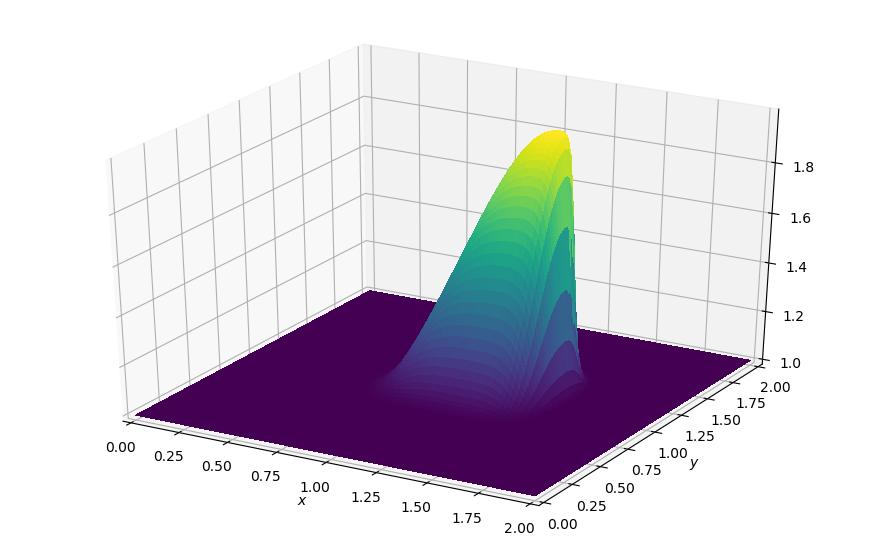

In [32]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

# Reset our data field and ICs
init_hat(field=u.data[0], dx=dx, dy=dy, value=2.)
init_hat(field=v.data[0], dx=dx, dy=dy, value=2.)

op = Operator([update_u, update_v] + bc_u + bc_v)
op(time=nt, dt=dt)

plot_field(u.data[0])

Excellent, we have now a scalar implementation of a convection problem, but this can be writen as a single vectorial equation:

$\frac{d U}{dt} + \nabla(U)U = 0$

Let's now use devito vectorial utilities and implement the vectorial equation

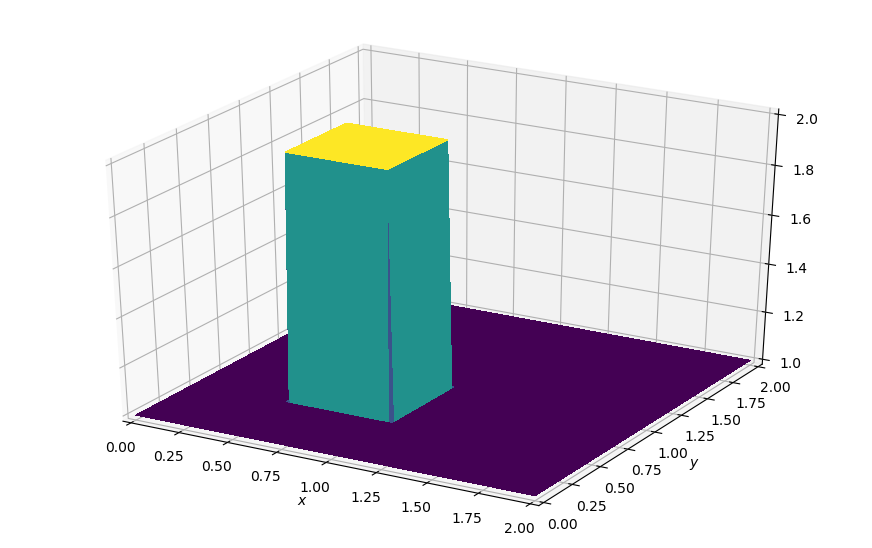

In [33]:
from devito import VectorTimeFunction, grad

U = VectorTimeFunction(name='U', grid=grid, save= steps)
init_hat(field=U[0].data[0], dx=dx, dy=dy, value=2.)
init_hat(field=U[1].data[0], dx=dx, dy=dy, value=2.)

plot_field(U[1].data[0])

eq_u = Eq(U.dt + grad(U)*U)

We now have a vectorial equation. Unlike hte previous case, we do not need to play woth legt/right derivatives
as the automated staggering of vectorial function takes care of it.

In [34]:
eq_u

Eq(Vector(U_x(time, x + h_x/2, y)*Derivative(U_x(time, x + h_x/2, y), x) + U_y(time, x, y + h_y/2)*Derivative(U_x(time, x + h_x/2, y), y) + Derivative(U_x(time, x + h_x/2, y), time), U_x(time, x + h_x/2, y)*Derivative(U_y(time, x, y + h_y/2), x) + U_y(time, x, y + h_y/2)*Derivative(U_y(time, x, y + h_y/2), y) + Derivative(U_y(time, x, y + h_y/2), time)), 0)

Then we set the nboundary conditions

In [35]:
x, y = grid.dimensions
t = grid.stepping_dim
bc_u = [Eq(U[0][t+1, 0, y], 1.)]  # left
bc_u += [Eq(U[0][t+1, nx-1, y], 1.)]  # right
bc_u += [Eq(U[0][t+1, x, ny-1], 1.)]  # top
bc_u += [Eq(U[0][t+1, x, 0], 1.)]  # bottom
bc_v = [Eq(U[1][t+1, 0, y], 1.)]  # left
bc_v += [Eq(U[1][t+1, nx-1, y], 1.)]  # right
bc_v += [Eq(U[1][t+1, x, ny-1], 1.)]  # top
bc_v += [Eq(U[1][t+1, x, 0], 1.)]  # bottom

In [36]:
# We can use the same SymPy trick to generate two
# stencil expressions, one for each field update.
stencil_U = solve(eq_u, U.forward)
update_U = Eq(U.forward, stencil_U, subdomain=grid.interior)

ValueError: Expected Dimension w.r.t. which to differentiate

And we have the update (stencil) as a vectorial equation once again

In [ ]:
update_U

We finally run the operator

In [ ]:
#NBVAL_IGNORE_OUTPUT
op = Operator([update_U] + bc_u + bc_v)
op(time=nt, dt=dt)

# The result is indeed the expected one.
plot_field(U[0].data[0])

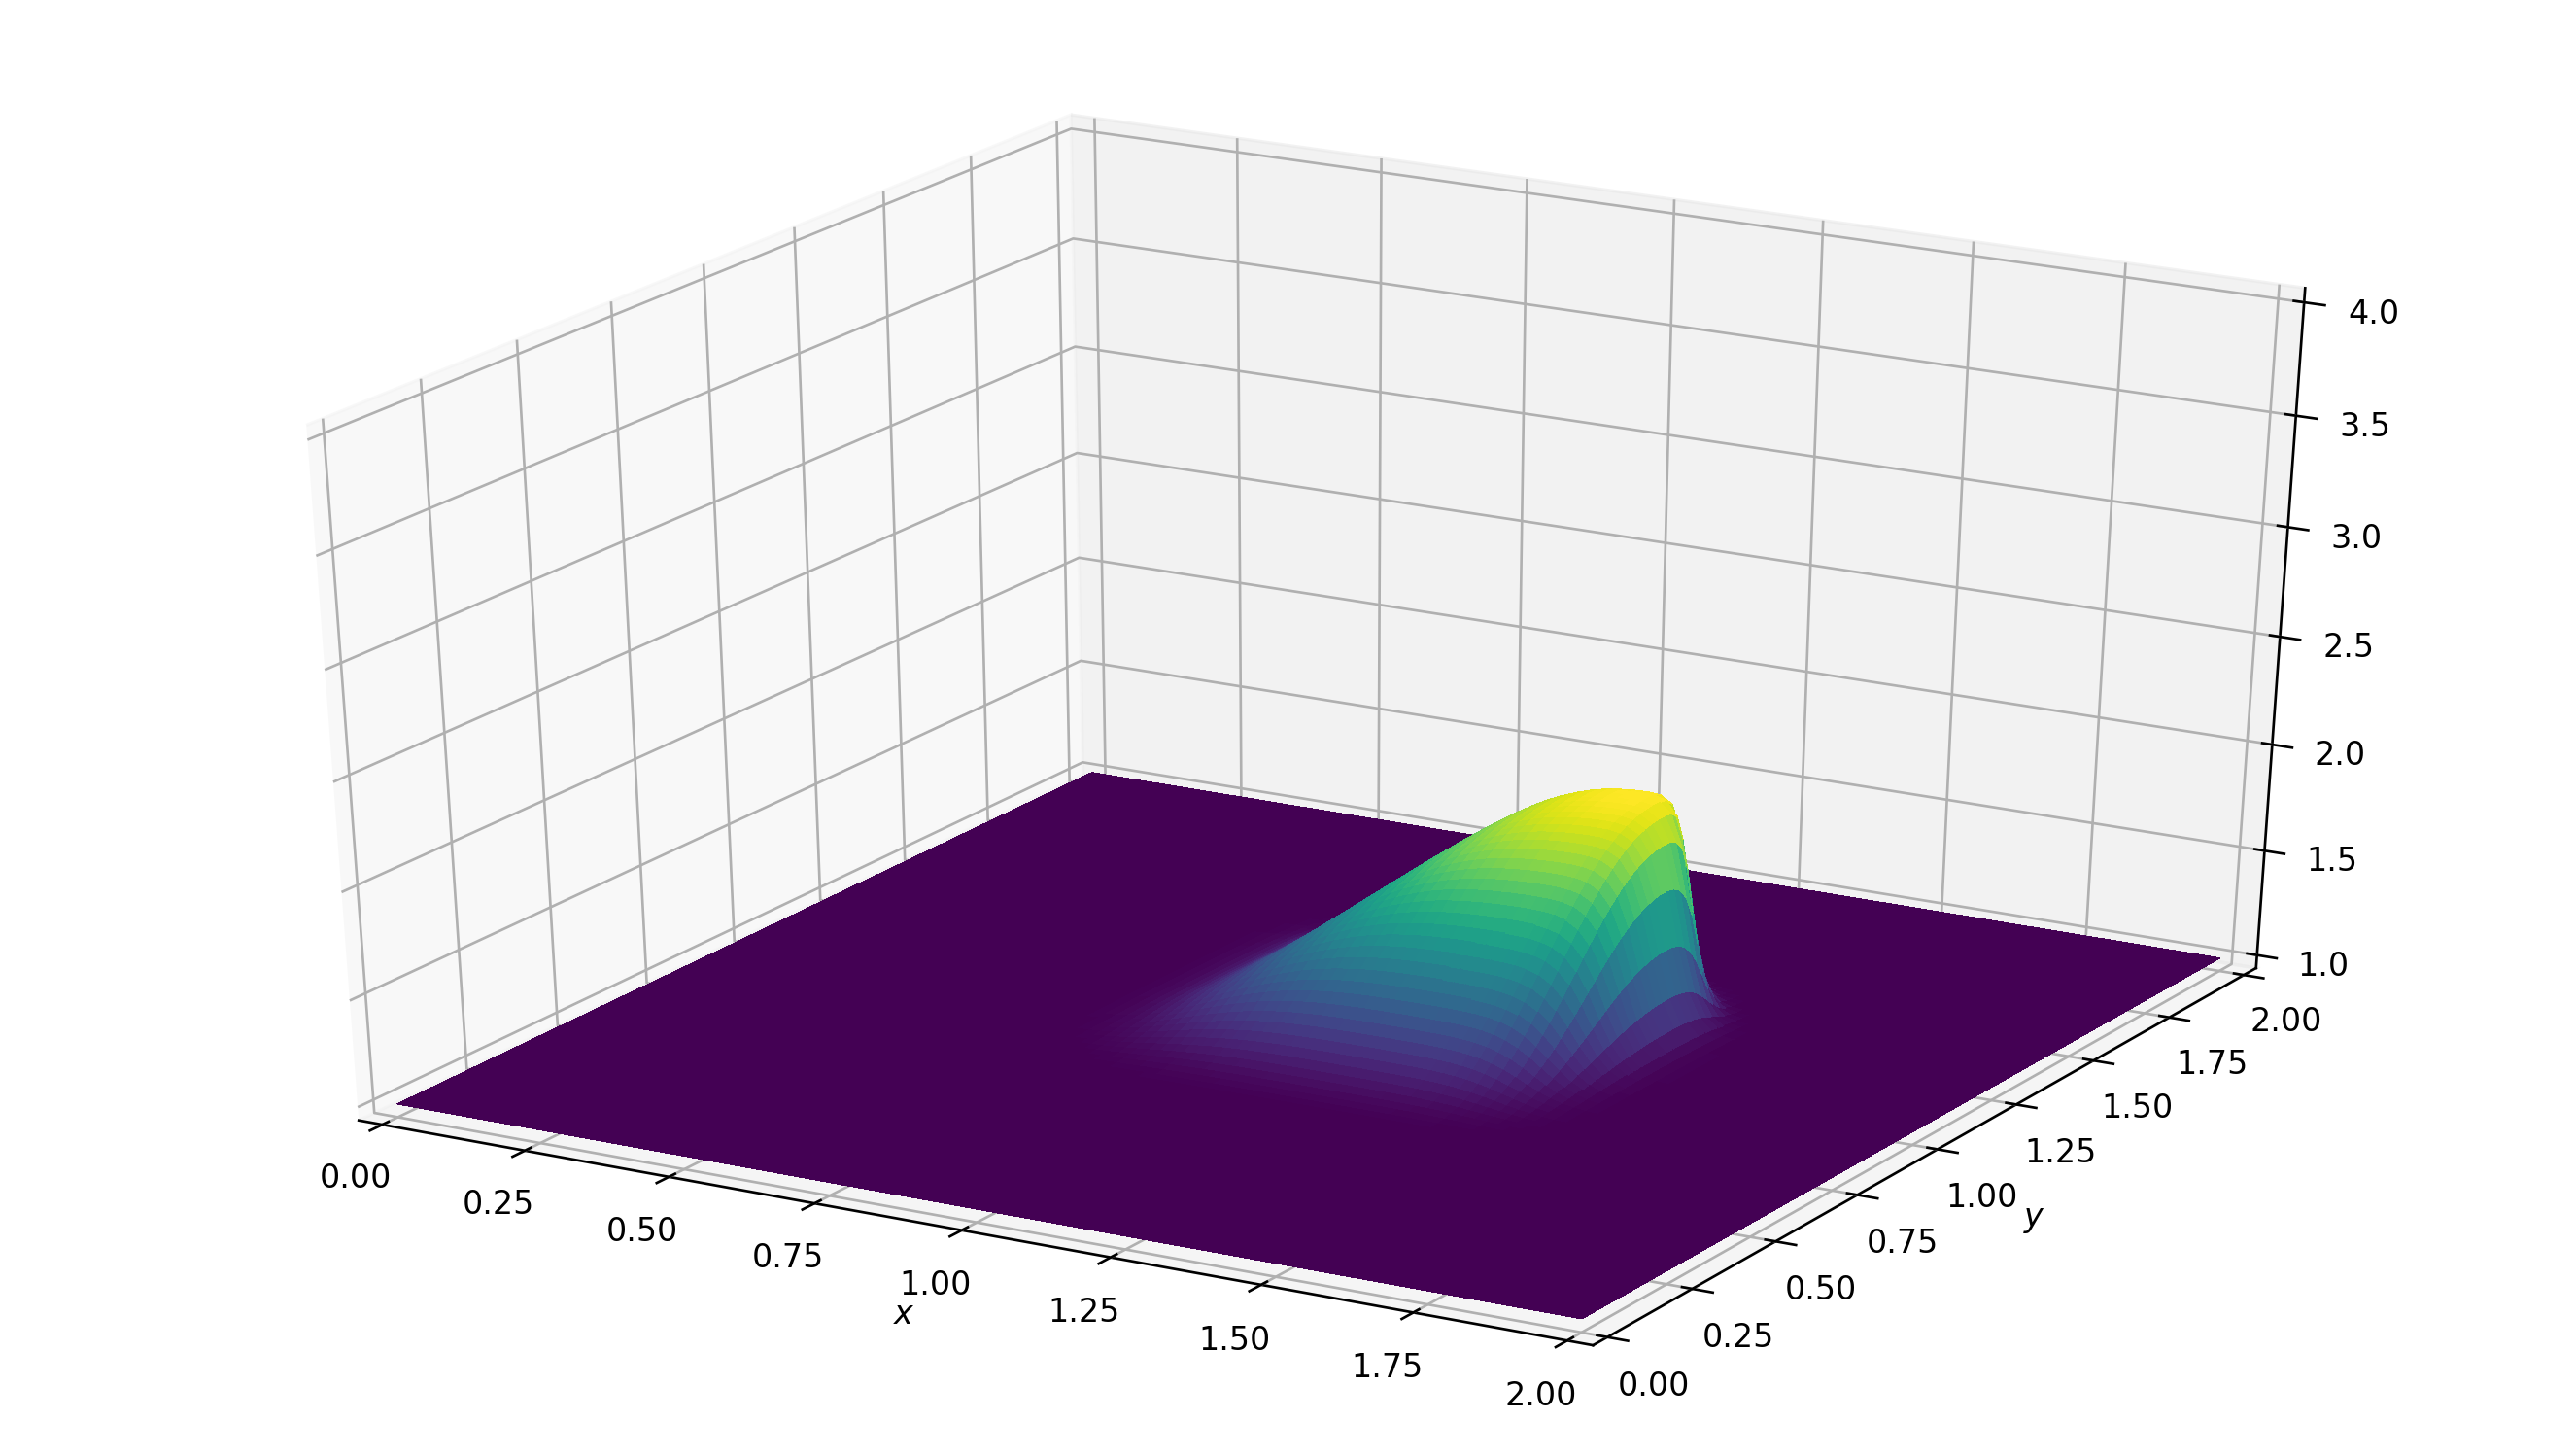

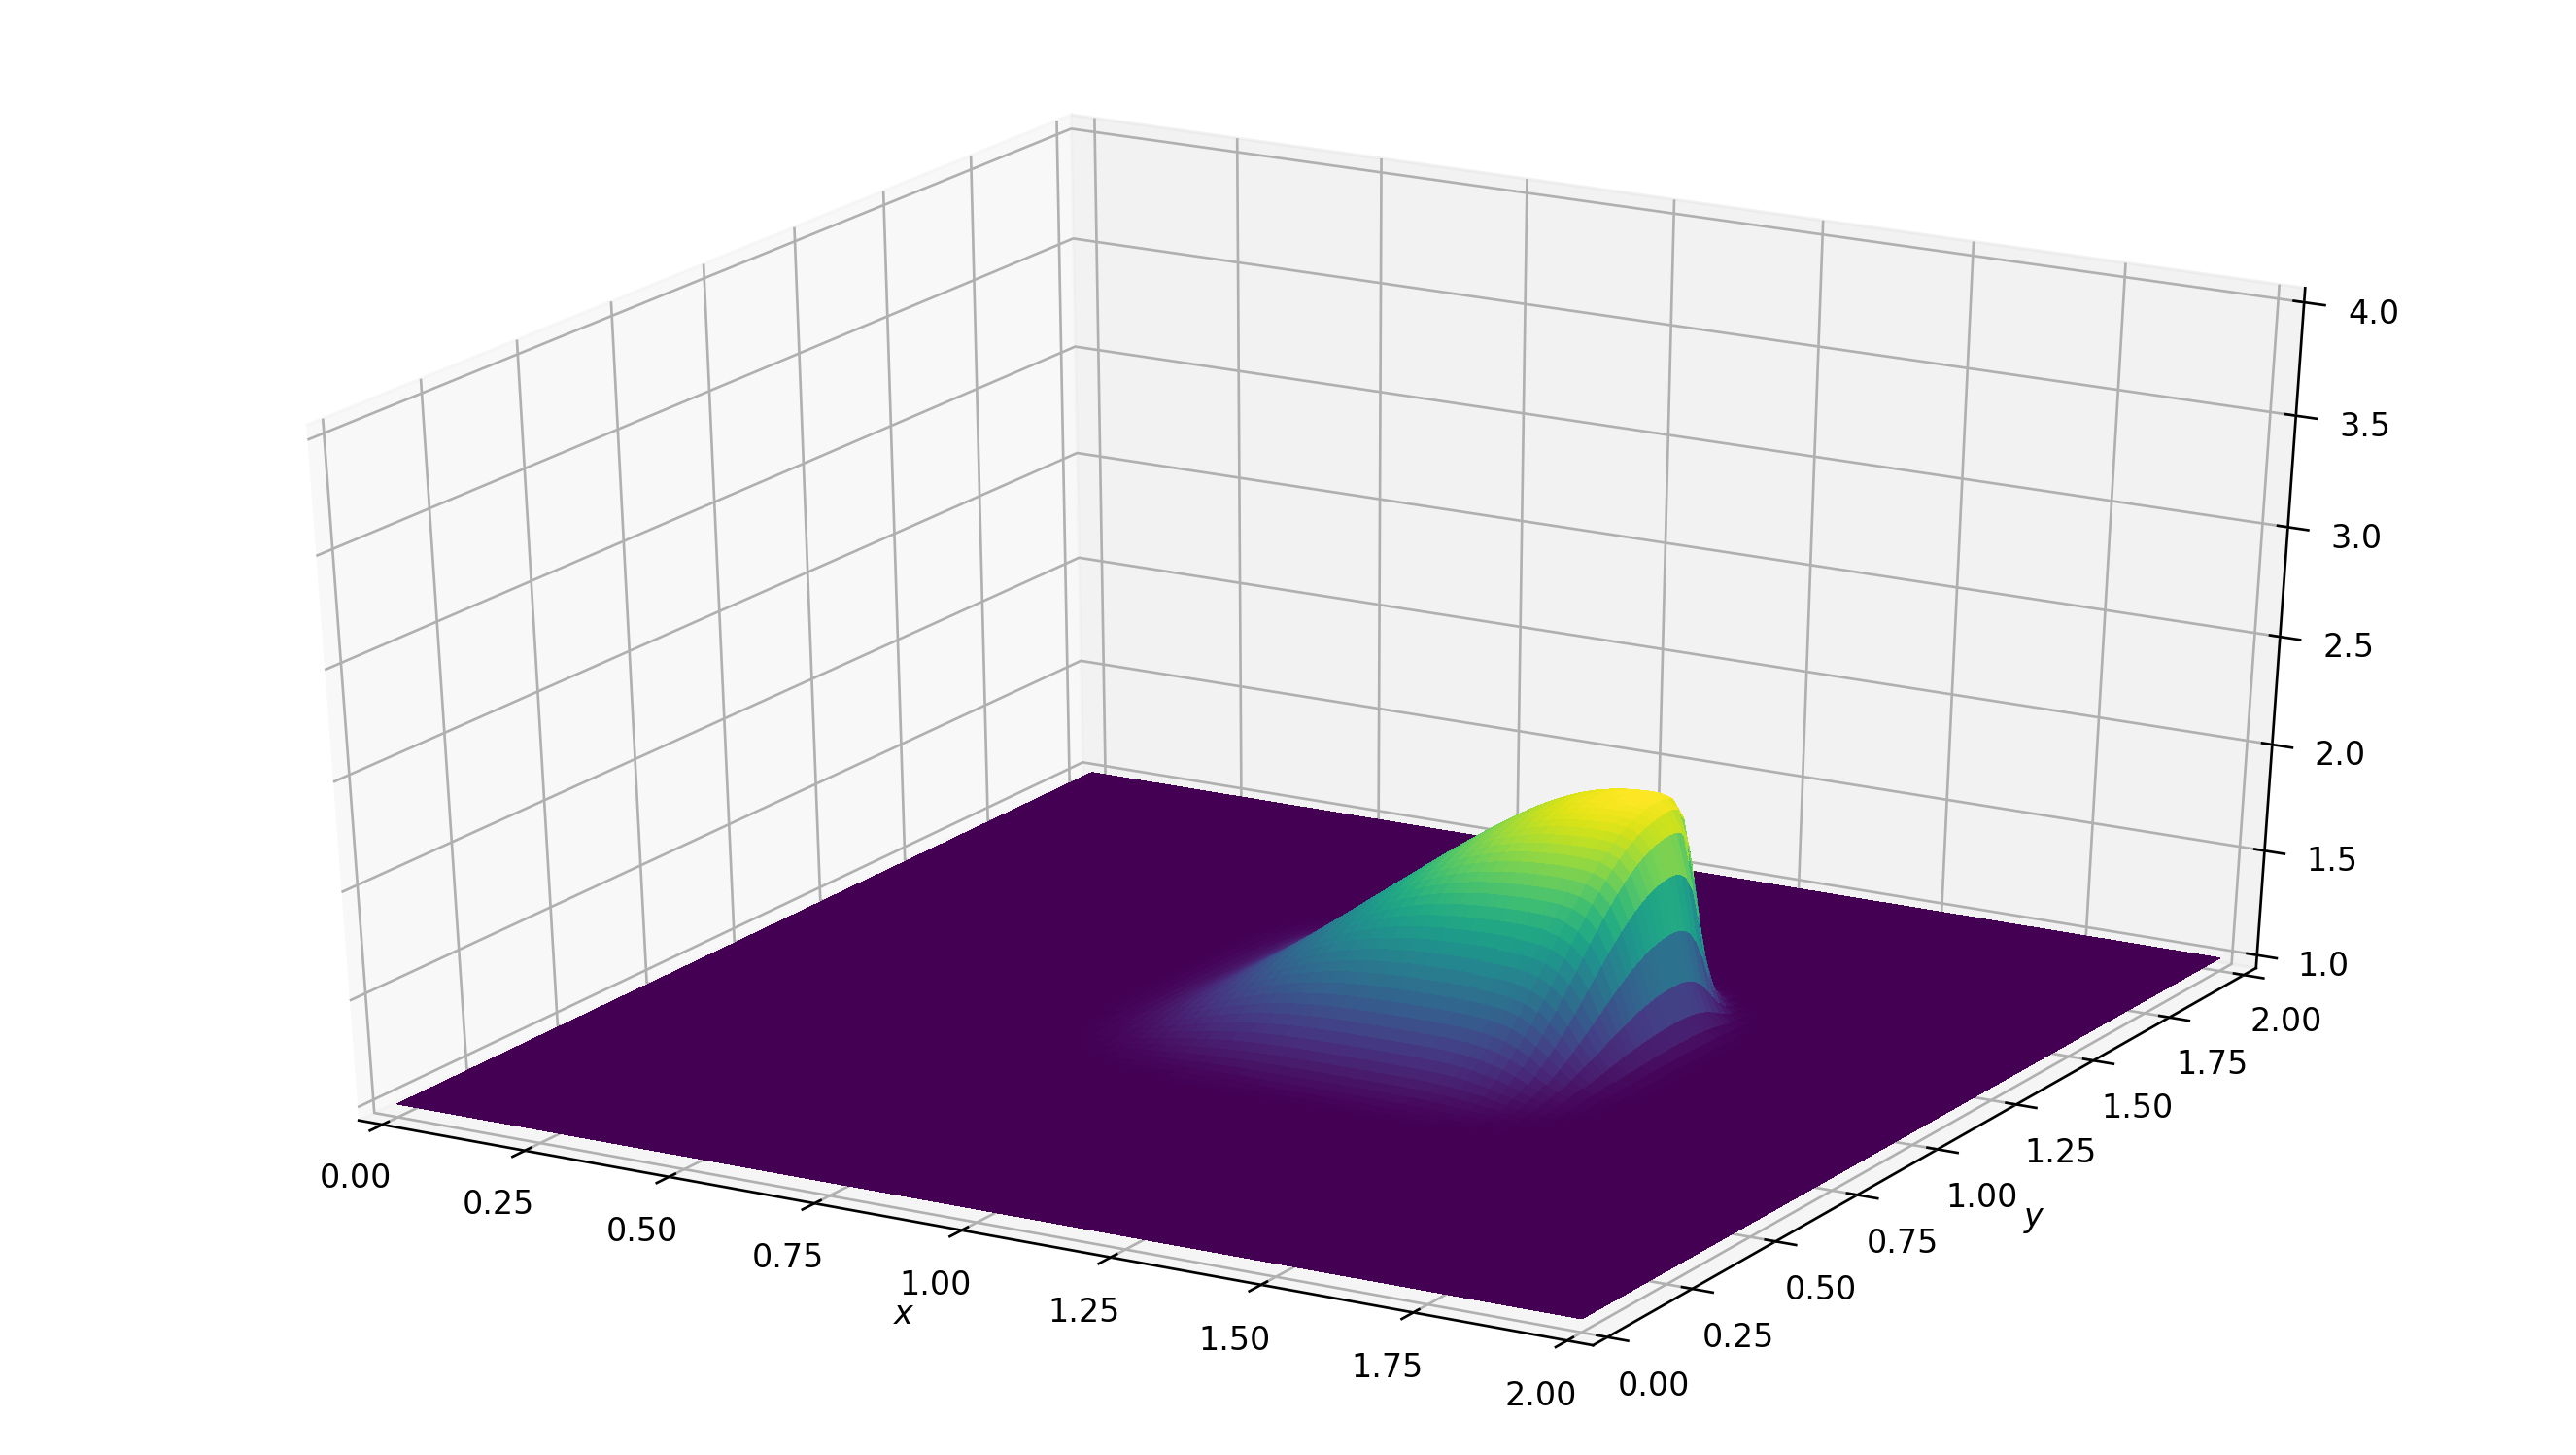

In [29]:
from devito import norm
assert np.isclose(norm(u), norm(U[0]), rtol=1e-5, atol=0)

from devito import mmax, mmin
from matplotlib import cm

import matplotlib.pyplot as plt

xg = np.linspace(grid.origin[0].data,
                 grid.extent[0] + grid.origin[0].data,
                 grid.shape[0])


#make_test_video(u)

#umin = mmin(u)/4
#umax = mmax(u)/4
    #umin = -10.
    #umax = 10.
#nlevels = 10

#levels = list(np.linspace(umin, umax, nlevels))

#X, Z = np.mgrid[-abs_lay: Lx+abs_lay+1e-10: dx, -abs_lay: Lz+abs_lay+1e-10: dz]



def plot_save_field(field, filename, xmin=0., xmax=2., ymin=0., ymax=2., zmin=None, zmax=4,
               view=None, linewidth=0):
    """
    Utility plotting routine for 2D data.

    Parameters
    ----------
    field : array_like
        Field data to plot.
    xmax : int, optional
        Length of the x-axis.
    ymax : int, optional
        Length of the y-axis.
    view: int, optional
        View point to intialise.
    """
    if xmin > xmax or ymin > ymax:
        raise ValueError("Dimension min cannot be larger than dimension max.")
    if (zmin is not None and zmax is not None):
        if zmin > zmax:
            raise ValueError("Dimension min cannot be larger than dimension max.")
    elif(zmin is None and zmax is not None):
        if np.min(field) >= zmax:
            warning("zmax is less than field's minima. Figure deceptive.")
    elif(zmin is not None and zmax is None):
        if np.max(field) <= zmin:
            warning("zmin is larger than field's maxima. Figure deceptive.")
    x_coord = np.linspace(xmin, xmax, field.shape[0])
    y_coord = np.linspace(ymin, ymax, field.shape[1])
    fig = plt.figure(figsize=(14, 8), dpi=240)
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x_coord, y_coord, indexing='ij')
    ax.plot_surface(X, Y, field[:], cmap=cm.viridis, rstride=1, cstride=1,
                    linewidth=linewidth, antialiased=False)

    # Enforce axis measures and set view if given
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    if zmin is None:
        zmin = np.min(field)
    if zmax is None:
        zmax = np.max(field)
    ax.set_zlim(zmin, zmax)

    if view is not None:
        ax.view_init(*view)

    # Label axis
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.savefig(filename)
    #plt.show()
    plt.close








for i in range (U.shape[0]):
    filename = 'im' + str("{:03d}".format(i)) + '.png'
    #fig = plt.figure(figsize=(16, 8))
    #ax1 = fig.add_subplot(111)
    plot_save_field(u.data[i, :, :],filename)
    print
    
    #ax1.plot(x, y, '-b')
    #cont = ax1.contourf(X,Z,u.data[i,:,:], levels, cmap=cm.seismic)
    #fig.colorbar(cont)
    #ax1.axis([0, Lx, 0, Lz])
    #ax1.set_xlabel('$x$')
    #ax1.set_ylabel('$z$')

    #plt.gca().invert_yaxis()
    #plt.savefig(filename)
    #plt.close()

#ffmpeg -framerate 30 -pattern_type glob -i '*.png'   -c:v libx264 -pix_fmt yuv420p out.mp4